<a href="https://colab.research.google.com/github/sammy-suyama/PythonBayesianMLBook/blob/main/chapter3/3_4_%E4%B8%80%E8%88%AC%E5%8C%96%E7%B7%9A%E5%BD%A2%E3%83%A2%E3%83%87%E3%83%AB_%E3%83%AD%E3%82%B8%E3%82%B9%E3%83%86%E3%82%A3%E3%83%83%E3%82%AF%E5%9B%9E%E5%B8%B0%E3%83%A2%E3%83%87%E3%83%AB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title install packages
!pip install watermark
#!pip install pymc3==3.11.4
!pip install pymc3

In [ ]:
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import arviz as az

sns.set_context('talk', font_scale=0.8)

In [ ]:
# アイリスデータセットの読み込み
iris_dataset = sns.load_dataset('iris')

# サンプルデータ数
N = 50

# setosaとversicolorのみ抽出
iris_dataset_2species = iris_dataset[iris_dataset['species'].isin(['setosa', 'versicolor'])].copy()

# 使用するデータをサンプリング
iris_dataset_use = iris_dataset_2species.sample(N, random_state=1)

# 説明変数
x_data = iris_dataset_use[['sepal_length', 'sepal_width']].copy().values
# バイアス項の追加
x_data_add_bias = np.concatenate([x_data, np.ones((N,1))],axis=1)

# 目的変数
y_data = pd.Categorical(iris_dataset_use['species']).codes

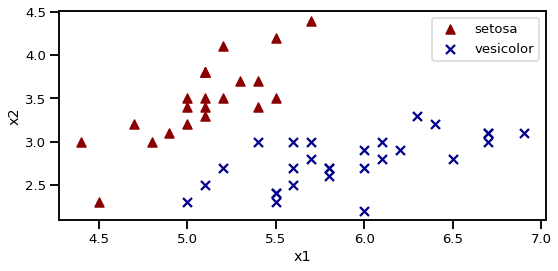

In [ ]:
fig, ax = plt.subplots(figsize=(8, 4))

# データをspeciesで分割して可視化
x_data_set = x_data[y_data==0]
x_data_ves = x_data[y_data==1]

ax.scatter(x=x_data_set[:,0], y=x_data_set[:,1], color='darkred', marker='^',label='setosa')
ax.scatter(x=x_data_ves[:,0], y=x_data_ves[:,1], color='darkblue', marker='x', label='vesicolor')

ax.set_xlabel('x1')
ax.set_ylabel('x2');
ax.legend()
plt.tight_layout()

In [ ]:
import pymc3 as pm

In [ ]:
# モデルの定義
with pm.Model() as model:
    # 説明変数
    x = pm.Data("x", x_data_add_bias)
    # 推論対象のパラメータ事前分布
    w = pm.Normal('w', mu=0.0, sigma=1.0, shape=3)
    # 尤度関数
    y = pm.Bernoulli('y', logit_p =w.dot(x.T), observed=y_data)

In [ ]:
with model:
    # MCMCによる推論
    trace = pm.sample(draws=3000, tune=1000, chains=3, random_seed=1, return_inferencedata=True)

WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (3 chains in 1 job)
NUTS: [w]


Sampling 3 chains for 1_000 tune and 3_000 draw iterations (3_000 + 9_000 draws total) took 42 seconds.
The acceptance probability does not match the target. It is 0.8846114697147002, but should be close to 0.8. Try to increase the number of tuning steps.


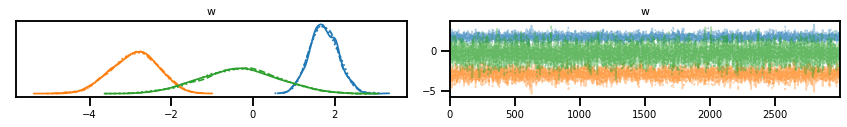

In [ ]:
az.plot_trace(trace);
plt.tight_layout()

In [ ]:
for var_info in az.rhat(trace).values():
  print(var_info.name, var_info.values.round(3), sep=' ')

w [1.001 1.001 1.001]


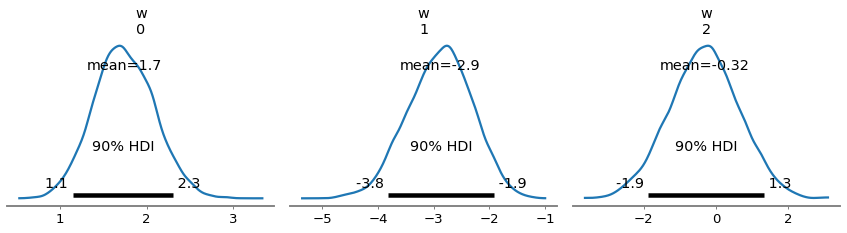

In [ ]:
az.plot_posterior(trace, hdi_prob=0.9, figsize=(12,3.5));
plt.tight_layout()

(2.0, 4.5)

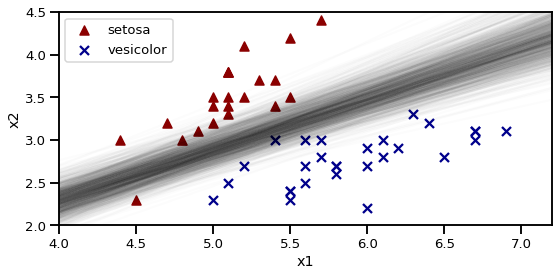

In [ ]:
# サンプルの取り出し(チェーン3つ分を結合)
w_mcmc_samples = trace.posterior['w'].values.reshape(9000,3)

#　各次元ごとに取り出し
w1_samples = w_mcmc_samples[:,0]
w2_samples = w_mcmc_samples[:,1]
w3_samples = w_mcmc_samples[:,2]

fig, ax = plt.subplots(figsize=(8, 4))
# サンプルデータ
ax.scatter(x=x_data_set[:,0], y=x_data_set[:,1], color='darkred', marker='^',label='setosa')
ax.scatter(x=x_data_ves[:,0], y=x_data_ves[:,1], color='darkblue', marker='x', label='vesicolor')

N_new = 10
x1 = np.linspace(4.0, 7.2, N_new)
for i in range(0, 9000, 10):
  # x1に対してθ=0.5となるx2
  x2 = - w3_samples[i]/w2_samples[i]-w1_samples[i]/w2_samples[i]*x1
  ax.plot(x1, x2, alpha=0.01, color='black')
ax.set_xlabel('x1')
ax.set_ylabel('x2');
ax.legend()
plt.tight_layout()
ax.set_xlim(4.0, 7.2);ax.set_ylim(2.0, 4.5)

In [ ]:
# 2次元のグリッド状データ作成（100×100）
N_new = 100
x1_linspace = np.linspace(4.0, 7.2, N_new)
x2_linspace = np.linspace(2.0, 4.5, N_new)
x1_grid, x2_grid = np.meshgrid(x1_linspace, x2_linspace)
x_new = np.array([[x1, x2]  for x1, x2 in zip(x1_grid.ravel(), x2_grid.ravel())])
x_new_add_bias = np.concatenate([x_new, np.ones((N_new**2, 1))], axis=1)

with model:
  # 検証用データをモデルに入力
  pm.set_data({"x": x_new_add_bias})
  # 予測分布からサンプリング
  pred = pm.sample_posterior_predictive(trace, samples=3000, random_seed=1)

y_pred_samples = pred['y']

/usr/local/lib/python3.7/dist-packages/pymc3/sampling.py:1690: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


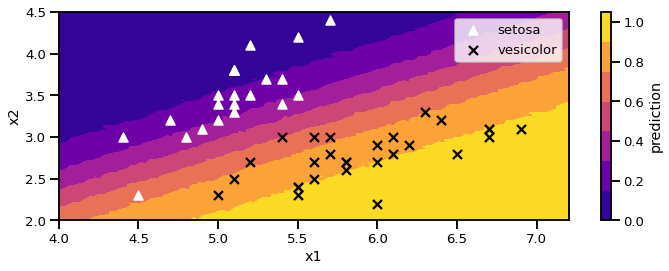

In [ ]:
fig, ax = plt.subplots(figsize=(10, 4))
# 等高線図
contourf = ax.contourf(x1_grid, x2_grid, y_pred_samples.mean(axis=0).reshape(N_new,N_new), cmap="plasma")
#　サンプルデータ
ax.scatter(x=x_data_set[:,0], y=x_data_set[:,1], color='white', marker='^',label='setosa')
ax.scatter(x=x_data_ves[:,0], y=x_data_ves[:,1], color='black', marker='x', label='vesicolor')
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.legend()
cbar = fig.colorbar(contourf, ax=ax)
cbar.set_label('prediction')
cbar.set_ticks(ticks=np.arange(0,1.1,0.2))
plt.tight_layout();

In [ ]:
%load_ext watermark
%watermark --iversions

numpy     : 1.21.6
pandas    : 1.3.5
seaborn   : 0.11.2
matplotlib: 3.2.2
scipy     : 1.4.1
arviz     : 0.12.1
pymc3     : 3.11.4
IPython   : 5.5.0

